# Manejo de datos: Combinar y modificar la forma de nuestros datos

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sqlite3

# Make connection to db
dat = sqlite3.connect("./drive/MyDrive/football(1).sqlite")

# Extract tables to dfs
country_df = pd.read_sql_query("select * from country", con = dat)
league_df = pd.read_sql_query("select * from league", con = dat)
match_df = pd.read_sql_query("select * from match", con = dat).iloc[:, :11]
team_df = pd.read_sql_query("select * from team", con = dat)


In [ ]:
cursor = dat.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


## Combinar/unir/mezclar DataFrames

![alt text](https://storage.googleapis.com/campus-cvs/lectures/3.4%20Merge%20Methods.png "Merge Methods")

### Joins estilo base de datos relacional

Las operaciones de combinación o combinación combinan conjuntos de datos al vincular filas usando una o más claves.
Estas operaciones son fundamentales para las bases de datos relacionales (por ejemplo, basadas en SQL). la fusión
La función en pandas es el principal punto de entrada para usar estos algoritmos en sus datos.

In [ ]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                    'data1': range(7)})
df2 = pd.DataFrame({'key': ['a', 'b', 'd'],
                    'data2': range(3)})
print(df1)
print('---------------')
print(df2)

  key  data1
0   b      0
1   b      1
2   a      2
3   c      3
4   a      4
5   a      5
6   b      6
---------------
  key  data2
0   a      0
1   b      1
2   d      2


Este es un ejemplo de una unión de muchos a uno; los datos en df1 tienen múltiples filas etiquetadas como
***b***, mientras que df2 tiene solo una fila para cada valor en la columna clave. Fusión de llamadas
con estos objetos obtenemos:

In [ ]:
pd.merge(df1, df2)

key  data1  data2
0   b      0      1
1   b      1      1
2   b      6      1
3   a      2      0
4   a      4      0
5   a      5      0

Tenga en cuenta que no especifiqué en qué columna unirse. Si esa información no es específica
De acuerdo, merge utiliza los nombres de las columnas superpuestas como claves. Es una buena práctica para
especificar explícitamente

In [ ]:
pd.merge(df1, df2, on='key')

key  data1  data2
0   b      0      1
1   b      1      1
2   b      6      1
3   a      2      0
4   a      4      0
5   a      5      0


Si los nombres de las columnas son diferentes en cada objeto, puede especificarlos por separado

In [ ]:
league_df.head(2)

id  country_id                    name
0     1           1  Belgium Jupiler League
1  1729        1729  England Premier League

In [ ]:
country_df.head(2)

id     name
0     1  Belgium
1  1729  England

In [ ]:
pd.read_sql_query("""
select *
from league
left join country
on league.country_id = country.id
""", con = dat).head(2)

id  country_id                    name    id     name
0     1           1  Belgium Jupiler League     1  Belgium
1  1729        1729  England Premier League  1729  England

In [ ]:
league_df.columns

Index(['id', 'country_id', 'name'], dtype='object')

In [ ]:
country_df.columns

Index(['id', 'name'], dtype='object')

In [ ]:
pd.merge(
    league_df,
    country_df,
    left_on="country_id",
    right_on="id",
    how="left"
).head(2)

id_foo  country_id                name_foo  id_bar name_bar
0       1           1  Belgium Jupiler League       1  Belgium
1    1729        1729  England Premier League    1729  England

In [ ]:
pd.merge(
    league_df,
    country_df,
    left_on="country_id",
    right_on="id"
).sample(2)

id_x  country_id                  name_x   id_y       name_y
9  21518       21518         Spain LIGA BBVA  21518        Spain
5  13274       13274  Netherlands Eredivisie  13274  Netherlands

Puede notar que los valores 'c' y 'd' y los datos asociados faltan en el
resultado. Por defecto, merge hace una unión 'interna'; las claves en el resultado son la intersección
ción, o el conjunto común que se encuentra en ambas tablas. Otras opciones posibles son 'left,
'right' y 'outter'. La unión exterior toma la unión de las llaves, combinando las
efecto de aplicar combinaciones izquierda y derecha:


Las fusiones de muchos a muchos tienen un comportamiento bien definido, aunque no necesariamente intuitivo.

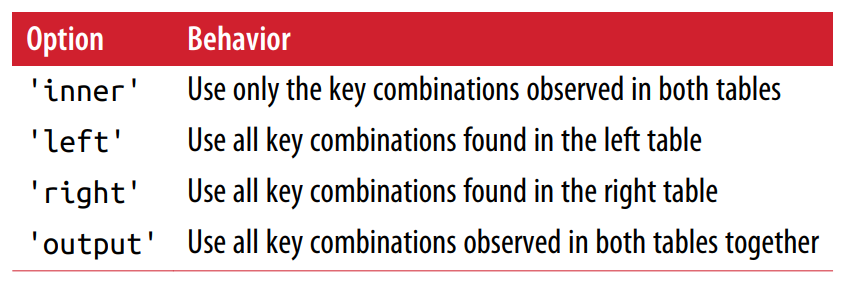


In [ ]:
# left
pd.merge(df1, df2, how="left", on="key")

key  data1  data2
0   b      0    1.0
1   b      1    1.0
2   a      2    0.0
3   c      3    NaN
4   a      4    0.0
5   a      5    0.0
6   b      6    1.0

In [ ]:
# outer
pd.merge(df1, df2, how="outer")

key  data1  data2
0   b    0.0    1.0
1   b    1.0    1.0
2   b    6.0    1.0
3   a    2.0    0.0
4   a    4.0    0.0
5   a    5.0    0.0
6   c    3.0    NaN
7   d    NaN    2.0

In [ ]:
# inner
pd.merge(df1, df2, how="inner")

key  data1  data2
0   b      0      1
1   b      1      1
2   b      6      1
3   a      2      0
4   a      4      0
5   a      5      0

Para fusionarse con varias columnas, pasar una lista de nombres de columna:

In [ ]:
left = pd.DataFrame({'key1': ['foo', 'foo', 'bar'],
                     'key2': ['one', 'two', 'one'],
                     'lval': [1, 2, 3]})
right = pd.DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                      'key2': ['one', 'one', 'one', 'two'],
                      'rval': [4, 5, 6, 7]})
print(left)
print('---------------')
print(right)
print('---------------')

  key1 key2  lval
0  foo  one     1
1  foo  two     2
2  bar  one     3
---------------
  key1 key2  rval
0  foo  one     4
1  foo  one     5
2  bar  one     6
3  bar  two     7
---------------


In [ ]:
pd.merge(
    left,
    right,
    on=['key1', 'key2'],
    how='outer'
)

key1 key2  lval  rval
0  foo  one   1.0   4.0
1  foo  one   1.0   5.0
2  foo  two   2.0   NaN
3  bar  one   3.0   6.0
4  bar  two   NaN   7.0

Un último problema a considerar en las operaciones de combinación es el tratamiento de las columnas superpuestas.
nombres Si bien puede abordar la superposición manualmente, merge tiene una opción de sufijos para especificar cadenas para agregar
a nombres superpuestos en los objetos DataFrame izquierdo y derecho:

In [ ]:

pd.merge(
    league_df,
    country_df,
    left_on="country_id",
    right_on="id",
    how="left",
    suffixes=['_league', '_county']
).head(3)

id_league  country_id             name_league  id_county name_county
0          1           1  Belgium Jupiler League          1     Belgium
1       1729        1729  England Premier League       1729     England
2       4769        4769          France Ligue 1       4769      France

### Fusionar datos a partir de sus indices

En algunos casos, las claves de combinación en un DataFrame se encontrarán en su índice. En esto
caso, puede pasar left_index=True o right_index=True (o ambos) para indicar que
el índice debe usarse como la clave de combinación

In [ ]:
left1 = pd.DataFrame({'key': ['a', 'b', 'a', 'a', 'b', 'c'],
                      'value': range(6)})
right1 = pd.DataFrame({'group_val': [3.5, 7]}, index=['a', 'b'])
print(left1)
print('---------------')
print(right1)
print('---------------')

  key  value
0   a      0
1   b      1
2   a      2
3   a      3
4   b      4
5   c      5
---------------
   group_val
a        3.5
b        7.0
---------------


In [ ]:
left1

key  value
0   a      0
1   b      1
2   a      2
3   a      3
4   b      4
5   c      5

In [ ]:
right1

group_val
a        3.5
b        7.0

In [ ]:
pd.merge(
    left1,
    right1,
    left_on="key",
    right_index=True,
    how="outer"
)

key  value  group_val
0   a      0        3.5
2   a      2        3.5
3   a      3        3.5
1   b      1        7.0
4   b      4        7.0
5   c      5        NaN

dado que el método de fusión predeterminado es intersectar las teclas de unión, en su lugar puede formar el
unión de ellos con una unión externa:

In [ ]:
print(left1)
print('---------------')
print(right1)
print('---------------')

  key  value
0   a      0
1   b      1
2   a      2
3   a      3
4   b      4
5   c      5
---------------
   group_val
a        3.5
b        7.0
---------------


### Challenge

Encuentra el resultado de todos los juegos entre los siguientes equipos:


| team_api_id | team_long_name |
|-------------|----------------|
| 8633        | Real Madrid    |
| 8634        | Barcelona      |

In [ ]:
equipos = team_df.loc[
    team_df['team_api_id'].isin([8633, 8634]),
    ['team_api_id', 'team_long_name']]
equipos

team_api_id  team_long_name
256         8633  Real Madrid CF
258         8634    FC Barcelona

In [ ]:
match_df.sample(3)

id  country_id  league_id     season  stage                 date  \
3372    3373        1729       1729  2012/2013     20  2012-12-29 00:00:00   
25898  25899       24558      24558  2015/2016     27  2016-04-09 00:00:00   
14649  14650       13274      13274  2012/2013     24  2013-02-24 00:00:00   

       match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
3372        1229310             10260              8659               2   
25898       1992185             10192              7896               7   
14649       1223180              8593             10217               1   

       away_team_goal  
3372                0  
25898               0  
14649               1

In [ ]:
equipos = team_df.loc[
    team_df['team_api_id'].isin([8633, 8634]),
    ['team_api_id', 'team_long_name']]

df1 = pd.merge(
    match_df[['season', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']],
    equipos,
    left_on="home_team_api_id",
    right_on="team_api_id",
    how="inner"
)

pd.merge(
    df1,
    equipos,
    left_on='away_team_api_id',
    right_on="team_api_id",
    how="inner",
    suffixes=["_home", "_away"]
)[['season', 'team_long_name_home', 'home_team_goal', 'away_team_goal', 'team_long_name_away']].sort_values('season')

season team_long_name_home  home_team_goal  away_team_goal  \
0   2008/2009      Real Madrid CF               2               6   
8   2008/2009        FC Barcelona               2               0   
1   2009/2010      Real Madrid CF               0               2   
9   2009/2010        FC Barcelona               1               0   
2   2010/2011      Real Madrid CF               1               1   
10  2010/2011        FC Barcelona               5               0   
3   2011/2012      Real Madrid CF               1               3   
11  2011/2012        FC Barcelona               1               2   
4   2012/2013      Real Madrid CF               2               1   
12  2012/2013        FC Barcelona               2               2   
5   2013/2014      Real Madrid CF               3               4   
13  2013/2014        FC Barcelona               2               1   
6   2014/2015      Real Madrid CF               3               1   
14  2014/2015        FC Barcelona               2               1   
7   2015/2016      Real Madrid CF               0               4   
15  2015/2016        FC Barcelona               1               2   

   team_long_name_away  
0         FC Barcelona  
8       Real Madrid CF  
1         FC Barcelona  
9       Real Madrid CF  
2         FC Barcelona  
10      Real Madrid CF  
3         FC Barcelona  
11      Real Madrid CF  
4         FC Barcelona  
12      Real Madrid CF  
5         FC Barcelona  
13      Real Madrid CF  
6         FC Barcelona  
14      Real Madrid CF  
7         FC Barcelona  
15      Real Madrid CF

### Concatenacion de datos a travez de un eje

En el contexto de objetos pandas como Series y DataFrame, tener ejes etiquetados
le permiten generalizar aún más la concatenación de matrices. En particular, usted tiene un número de cosas adicionales para pensar:


*   Si los objetos están indexados de manera diferente en los otros ejes, ¿deberíamos combinar los elementos distintos en estos ejes o utilizar sólo los valores compartidos (la intersección)?
*   ¿Los fragmentos concatenados de datos deben ser identificables en el resultado objeto?
*   ¿El “eje de concatenación” contiene datos que deben conservarse? En muchos casos, las etiquetas enteras predeterminadas en un DataFrame se descartan mejor durante concatenación.



La función concat en pandas proporciona una forma coherente de abordar cada una de estas
preocupaciones.

In [ ]:
s1 = pd.Series([0, 1], index=['a', 'b'])
s2 = pd.Series([2, 3, 4], index=['c', 'd', 'e'])
s3 = pd.Series([5, 6], index=['f', 'g'])

In [ ]:
pd.concat([s1, s2, s3])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

Por defecto, concat funciona a lo largo del axis = 0, produciendo otra Serie. Si pasa axis = 1,
en cambio, el resultado será un DataFrame (axis = 1 son las columnas):

In [ ]:
pd.concat([s1, s2, s3], axis=1)

0    1    2
a  0.0  NaN  NaN
b  1.0  NaN  NaN
c  NaN  2.0  NaN
d  NaN  3.0  NaN
e  NaN  4.0  NaN
f  NaN  NaN  5.0
g  NaN  NaN  6.0

In [ ]:
pd.concat([
    s1.reset_index(drop=True),
    s2.reset_index(drop=True),
    s3.reset_index(drop=True)], axis=1)

0  1    2
0  0.0  2  5.0
1  1.0  3  6.0
2  NaN  4  NaN

En este caso no hay solapamiento en el otro eje, que como podéis ver es el ordenado
unión (la unión 'outer') de los índices. En su lugar, puede cruzarlos pasando
join = 'inner':

In [ ]:
s4 = pd.concat([s1, s3])
s4

a    0
b    1
f    5
g    6
dtype: int64

In [ ]:
pd.concat([s1, s3, s4], axis=1)

0    1  2
a  0.0  NaN  0
b  1.0  NaN  1
f  NaN  5.0  5
g  NaN  6.0  6

Un problema potencial es que las piezas concatenadas no son identificables en el resultado. Suponga en su lugar, quería crear un índice jerárquico en el eje de concatenación. Para
hacer esto, use el argumento de las claves:

In [ ]:
print(s1)
print('---------------')
print(s2)
print('---------------')
print(s3)
print('---------------')
pd.concat([s1, s2, s3], keys=['uno', 'dos', 'tres'])

a    0
b    1
dtype: int64
---------------
c    2
d    3
e    4
dtype: int64
---------------
f    5
g    6
dtype: int64
---------------


uno   a    0
      b    1
dos   c    2
      d    3
      e    4
tres  f    5
      g    6
dtype: int64

En el caso de combinar Series a lo largo del axis = 1, las claves se convierten en los encabezados de columna de DataFrame

In [ ]:
pd.concat([s1, s2, s3], axis=1, keys=['uno', 'dos', 'tres'])

uno  dos  tres
a  0.0  NaN   NaN
b  1.0  NaN   NaN
c  NaN  2.0   NaN
d  NaN  3.0   NaN
e  NaN  4.0   NaN
f  NaN  NaN   5.0
g  NaN  NaN   6.0

La misma lógica se extiende a los objetos DataFrame:

In [ ]:
df1 = pd.DataFrame(np.arange(6).reshape(3, 2), index=['a', 'b', 'c'],
                   columns=['one', 'two'])
df2 = pd.DataFrame(5 + np.arange(4).reshape(2, 2), index=['a', 'c'],
                   columns=['three', 'four'])
print(df1)
print('---------------')
print(df2)
print('---------------')

   one  two
a    0    1
b    2    3
c    4    5
---------------
   three  four
a      5     6
c      7     8
---------------


In [ ]:
pd.concat([df1, df2])

one  two  three  four
a  0.0  1.0    NaN   NaN
b  2.0  3.0    NaN   NaN
c  4.0  5.0    NaN   NaN
a  NaN  NaN    5.0   6.0
c  NaN  NaN    7.0   8.0

In [ ]:
pd.concat([df1, df2], axis=1)

one  two  three  four
a    0    1    5.0   6.0
b    2    3    NaN   NaN
c    4    5    7.0   8.0

Si pasa un diccionario de objetos en lugar de una lista, las claves del diccionario se utilizarán para las claves
llave:

In [ ]:
pd.concat([df1, df2], axis=1, keys=['df1', 'df2'])

df1       df2     
  one two three four
a   0   1   5.0  6.0
b   2   3   NaN  NaN
c   4   5   7.0  8.0

In [ ]:
print(df1)
print('---------------')
print(df2)
print('---------------')


   one  two
a    0    1
b    2    3
c    4    5
---------------
   three  four
a      5     6
c      7     8
---------------


In [ ]:
pd.concat({"data 1": df1, "data 2": df2}, axis=1)

data 1     data 2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0


Una última consideración se refiere a los marcos de datos en los que el índice de fila no contiene
Cualquier dato relevante:

In [ ]:
df1 = pd.DataFrame(np.random.randn(3, 4), columns=['a', 'b', 'c', 'd'])
df2 = pd.DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])
print(df1)
print(df2)

          a         b         c         d
0 -1.127489  1.676375 -0.220189 -0.089568
1 -1.701801  0.668746  0.691135 -0.802160
2 -0.220081 -0.467817  1.253903  0.321261
          b         d         a
0  1.383485  0.484708 -2.197206
1  0.803211 -0.574199 -0.498943


### Combinando datos con traslape

Hay otra situación de combinación de datos que no se puede expresar como una combinación
o operación de concatenación. Puede tener dos conjuntos de datos cuyos índices se superponen por completo
o parte. Como ejemplo motivador, considere la función where de NumPy, que realiza
el equivalente orientado a matrices de una expresión if-else:

In [ ]:
a = pd.Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
              index=['f', 'e', 'd', 'c', 'b', 'a'])
b = pd.Series(np.arange(len(a), dtype=np.float64),
              index=['f', 'e', 'd', 'c', 'b', 'a'])
b[-1] = np.nan
print(a)
print('---------------')
print(b)
print('---------------')

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64
---------------
f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64
---------------


In [ ]:
a.combine_first(b)

f    0.0
e    2.5
d    2.0
c    3.5
b    4.5
a    NaN
dtype: float64


Series tiene un método combine_first, que realiza el equivalente de esta operación
junto con la lógica de alineación de datos habitual de pandas

In [ ]:
print(b[:-2])
print(a[2:])


f    0.0
e    1.0
d    2.0
c    3.0
dtype: float64
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64


Con DataFrames, combine_first hace lo mismo columna por columna, por lo que
puede pensar en ello como "parchar" datos faltantes en el objeto que llama con datos del
objeto que pasas:

In [ ]:
df1 = pd.DataFrame({'a': [1., np.nan, 5., np.nan],
                    'b': [np.nan, 2., np.nan, 6.],
                    'c': range(2, 18, 4)})
df2 = pd.DataFrame({'a': [5., 4., np.nan, 3., 7.],
                    'b': [np.nan, 3., 4., 6., 8.]})
print(df1)
print(df2)

     a    b   c
0  1.0  NaN   2
1  NaN  2.0   6
2  5.0  NaN  10
3  NaN  6.0  14
     a    b
0  5.0  NaN
1  4.0  3.0
2  NaN  4.0
3  3.0  6.0
4  7.0  8.0


In [ ]:
df1.combine_first(df2)

a    b     c
0  1.0  NaN   2.0
1  4.0  2.0   6.0
2  5.0  4.0  10.0
3  3.0  6.0  14.0
4  7.0  8.0   NaN

## Pivoteo de datos y cambio de forma de los datos

### Cambios de forma con indices jerarquicos

La indexación jerárquica proporciona una forma coherente de reorganizar los datos en un DataFrame.
Hay dos acciones principales:

Apilar
Esto "rota" o gira de las columnas en los datos a las filas
Desapilar
Esto gira de las filas a las columnas.

In [ ]:
data = pd.DataFrame(np.arange(6).reshape((2, 3)),
                    index=pd.Index(['Ohio', 'Colorado'], name='state'),
                    columns=pd.Index(['one', 'two', 'three'],
                    name='number'))
data

number    one  two  three
state                    
Ohio        0    1      2
Colorado    3    4      5

El uso del método de pila en estos datos pivota las columnas en las filas, produciendo un
Serie:

In [ ]:
result = data.stack()
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int64

In [ ]:
result.index

MultiIndex([(    'Ohio',   'one'),
            (    'Ohio',   'two'),
            (    'Ohio', 'three'),
            ('Colorado',   'one'),
            ('Colorado',   'two'),
            ('Colorado', 'three')],
           names=['state', 'number'])

A partir de una serie indexada jerárquicamente, puede reorganizar los datos de nuevo en una serie de datos.
Marco con unstack():

In [ ]:
result.unstack()

number    one  two  three
state                    
Ohio        0    1      2
Colorado    3    4      5

Por defecto, el nivel más interno está desapilado (lo mismo con la pila). Puede desapilar una
nivel diferente pasando un número de nivel o nombre:

In [ ]:
result.unstack(0)

state   Ohio  Colorado
number                
one        0         3
two        1         4
three      2         5

In [ ]:
result.unstack('state')

state   Ohio  Colorado
number                
one        0         3
two        1         4
three      2         5

Desapilar podría introducir datos faltantes si no se encuentran todos los valores en el nivel en cada uno de los subgrupos

In [ ]:
s1 = pd.Series([0, 1, 2, 3], index=['a', 'b', 'c', 'd'])
s2 = pd.Series([4, 5, 6], index=['c', 'd', 'e'])
data2 = pd.concat([s1, s2], keys=['one', 'two'])
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [ ]:
data2.unstack()

a    b    c    d    e
one  0.0  1.0  2.0  3.0  NaN
two  NaN  NaN  4.0  5.0  6.0


El apilamiento filtra los datos que faltan de forma predeterminada, por lo que la operación es más fácil de invertir

In [ ]:
data3 = data2.unstack()
data3

a    b    c    d    e
one  0.0  1.0  2.0  3.0  NaN
two  NaN  NaN  4.0  5.0  6.0

In [ ]:
data3.stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [ ]:
data3.stack(dropna=False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

Cuando desapila en un DataFrame, el nivel desapilado se convierte en el nivel más bajo en el resultado:

In [ ]:
df = pd.DataFrame({'left': result, 'right': result + 5},
                  columns=pd.Index(['left', 'right'], name='side'))

In [ ]:
df.index

MultiIndex([(    'Ohio',   'one'),
            (    'Ohio',   'two'),
            (    'Ohio', 'three'),
            ('Colorado',   'one'),
            ('Colorado',   'two'),
            ('Colorado', 'three')],
           names=['state', 'number'])

Al llamar a stack, podemos indicar el nombre del eje a apilar:

In [ ]:
df.unstack('state')#.unstack('state').stack('side')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

In [ ]:
df.stack('side')

state     number  side 
Ohio      one     left      0
                  right     5
          two     left      1
                  right     6
          three   left      2
                  right     7
Colorado  one     left      3
                  right     8
          two     left      4
                  right     9
          three   left      5
                  right    10
dtype: int64

### Pivotear de un formato "largo" a uno "ancho"

Una forma común de almacenar múltiples series de tiempo en bases de datos y CSV es en los llamados largos
o formato apilado. Carguemos algunos datos de ejemplo y hagamos una pequeña cantidad de series de tiempo
disputas y otra limpieza de datos:

In [ ]:
DATA_ROOT = 'https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition'

In [ ]:
data = pd.read_csv(DATA_ROOT + '/examples/macrodata.csv')
data.head()
periods = pd.PeriodIndex(year=data.year, quarter=data.quarter,
                         name='date')
columns = pd.Index(['realgdp', 'infl', 'unemp'], name='item')
data = data.reindex(columns=columns)
data.index = periods.to_timestamp('D', 'end')
ldata = data.stack().reset_index().rename(columns={0: 'value'})

In [ ]:
ldata.head()

date     item     value
0 1959-03-31 23:59:59.999999999  realgdp  2710.349
1 1959-03-31 23:59:59.999999999     infl     0.000
2 1959-03-31 23:59:59.999999999    unemp     5.800
3 1959-06-30 23:59:59.999999999  realgdp  2778.801
4 1959-06-30 23:59:59.999999999     infl     2.340

Este es el llamado formato largo para múltiples series de tiempo u otros datos de observación.
con dos o más claves (aquí, nuestras claves son fecha y artículo). Cada fila de la tabla representa
envía una única observación.
Los datos se almacenan con frecuencia de esta manera en bases de datos relacionales como MySQL, como un
esquema (nombres de columna y tipos de datos) permite el número de valores distintos en el
columna de elemento para cambiar a medida que se agregan datos a la tabla. En el ejemplo anterior, la fecha
y el elemento generalmente serían las claves principales (en el lenguaje de la base de datos relacional), ofreciendo
tanto la integridad relacional como las uniones más fáciles. En algunos casos, los datos pueden ser más difíciles.
culto para trabajar en este formato; es posible que prefiera tener un DataFrame que contenga
una columna por valor de elemento distinto indexado por marcas de tiempo en la columna de fecha. Datos-
El método de pivote de Frame realiza exactamente esta transformación:

In [ ]:
ldata.pivot(index='date', columns='item', values='value')

item                           infl    realgdp  unemp
date                                                 
1959-03-31 23:59:59.999999999  0.00   2710.349    5.8
1959-06-30 23:59:59.999999999  2.34   2778.801    5.1
1959-09-30 23:59:59.999999999  2.74   2775.488    5.3
1959-12-31 23:59:59.999999999  0.27   2785.204    5.6
1960-03-31 23:59:59.999999999  2.31   2847.699    5.2
...                             ...        ...    ...
2008-09-30 23:59:59.999999999 -3.16  13324.600    6.0
2008-12-31 23:59:59.999999999 -8.79  13141.920    6.9
2009-03-31 23:59:59.999999999  0.94  12925.410    8.1
2009-06-30 23:59:59.999999999  3.37  12901.504    9.2
2009-09-30 23:59:59.999999999  3.56  12990.341    9.6

[203 rows x 3 columns]


Los dos primeros valores pasados ​​son las columnas que se utilizarán respectivamente como fila y
índice de columna, luego, finalmente, una columna de valor opcional para llenar el DataFrame. Suponer
tenías dos columnas de valor que querías remodelar simultáneamente:

In [ ]:
ldata['value2'] = np.random.randn(len(ldata))
ldata[:10]

date     item     value    value2
0 1959-03-31 23:59:59.999999999  realgdp  2710.349 -0.100611
1 1959-03-31 23:59:59.999999999     infl     0.000 -1.490237
2 1959-03-31 23:59:59.999999999    unemp     5.800  0.469167
3 1959-06-30 23:59:59.999999999  realgdp  2778.801 -0.461633
4 1959-06-30 23:59:59.999999999     infl     2.340  0.479671
5 1959-06-30 23:59:59.999999999    unemp     5.100 -0.545600
6 1959-09-30 23:59:59.999999999  realgdp  2775.488  1.775851
7 1959-09-30 23:59:59.999999999     infl     2.740 -1.412017
8 1959-09-30 23:59:59.999999999    unemp     5.300  1.751314
9 1959-12-31 23:59:59.999999999  realgdp  2785.204 -0.527112

Al omitir el último argumento, obtiene un DataFrame con columnas jerárquicas:

In [ ]:
ldata.pivot(index='date', columns='item', values=['value', 'value2'])

value                     value2            \
item                           infl    realgdp unemp      infl   realgdp   
date                                                                       
1959-03-31 23:59:59.999999999  0.00   2710.349   5.8 -1.490237 -0.100611   
1959-06-30 23:59:59.999999999  2.34   2778.801   5.1  0.479671 -0.461633   
1959-09-30 23:59:59.999999999  2.74   2775.488   5.3 -1.412017  1.775851   
1959-12-31 23:59:59.999999999  0.27   2785.204   5.6  1.846851 -0.527112   
1960-03-31 23:59:59.999999999  2.31   2847.699   5.2 -0.397023  0.894950   
...                             ...        ...   ...       ...       ...   
2008-09-30 23:59:59.999999999 -3.16  13324.600   6.0  1.251397  0.063164   
2008-12-31 23:59:59.999999999 -8.79  13141.920   6.9 -0.406301 -0.757197   
2009-03-31 23:59:59.999999999  0.94  12925.410   8.1  1.345938  0.836715   
2009-06-30 23:59:59.999999999  3.37  12901.504   9.2 -0.509546 -0.408929   
2009-09-30 23:59:59.999999999  3.56  12990.341   9.6 -0.505677 -0.658933   

                                         
item                              unemp  
date                                     
1959-03-31 23:59:59.999999999  0.469167  
1959-06-30 23:59:59.999999999 -0.545600  
1959-09-30 23:59:59.999999999  1.751314  
1959-12-31 23:59:59.999999999 -0.776839  
1960-03-31 23:59:59.999999999  0.735137  
...                                 ...  
2008-09-30 23:59:59.999999999 -1.431343  
2008-12-31 23:59:59.999999999 -2.153533  
2009-03-31 23:59:59.999999999 -0.296045  
2009-06-30 23:59:59.999999999  0.537030  
2009-09-30 23:59:59.999999999  0.527908  

[203 rows x 6 columns]

Tenga en cuenta que pivote es equivalente a crear un índice jerárquico usando set_index después
bajado por una llamada para desapilar:

In [ ]:
unstacked = ldata.set_index(['date', 'item']).unstack('item')
unstacked[:7]

value                    value2            \
item                           infl   realgdp unemp      infl   realgdp   
date                                                                      
1959-03-31 23:59:59.999999999  0.00  2710.349   5.8  0.917390 -0.526438   
1959-06-30 23:59:59.999999999  2.34  2778.801   5.1 -0.863807 -1.258638   
1959-09-30 23:59:59.999999999  2.74  2775.488   5.3 -0.011193  1.029474   
1959-12-31 23:59:59.999999999  0.27  2785.204   5.6  0.050559  0.340824   
1960-03-31 23:59:59.999999999  2.31  2847.699   5.2 -0.162413 -1.135812   
1960-06-30 23:59:59.999999999  0.14  2834.390   5.2 -1.021099  0.318464   
1960-09-30 23:59:59.999999999  2.70  2839.022   5.6  0.792538 -0.885492   

                                         
item                              unemp  
date                                     
1959-03-31 23:59:59.999999999  0.451910  
1959-06-30 23:59:59.999999999 -0.676901  
1959-09-30 23:59:59.999999999  0.637634  
1959-12-31 23:59:59.999999999 -0.297695  
1960-03-31 23:59:59.999999999  0.435779  
1960-06-30 23:59:59.999999999 -0.827768  
1960-09-30 23:59:59.999999999 -0.258556

### Pivotear de un formato "ancho" a uno "largo"

Una operación inversa para pivotar para DataFrames es pandas.melt. En lugar de trans-
formando una columna en muchas en un nuevo DataFrame, fusiona múltiples columnas en
one, produciendo un DataFrame que es más largo que la entrada. Veamos un ejemplo:

In [ ]:
df = pd.DataFrame({'key': ['foo', 'bar', 'baz'],
                   '2010': [1, 2, 3],
                   '2015': [4, 5, 6],
                   '2020': [7, 8, 9]})
df

key  2010  2015  2020
0  foo     1     4     7
1  bar     2     5     8
2  baz     3     6     9

La columna 'key' puede ser un indicador de grupo, y las otras columnas son valores de datos.
Al usar pandas.melt, debemos indicar qué columnas (si las hay) son indicativas de grupo.tores Usemos 'clave' como el único indicador de grupo aquí:

In [ ]:
#pd.melt
melted_df = pd.melt(df, ['key'])
melted_df

key variable  value
0  foo     2010      1
1  bar     2010      2
2  baz     2010      3
3  foo     2015      4
4  bar     2015      5
5  baz     2015      6
6  foo     2020      7
7  bar     2020      8
8  baz     2020      9

Usando pivote, podemos remodelar de nuevo al diseño original:

In [ ]:
# df.pivot
melted_df.pivot(index='key', columns='variable', values='value').reset_index()

variable  key  2010  2015  2020
0         bar     2     5     8
1         baz     3     6     9
2         foo     1     4     7

Dado que el resultado del pivote crea un índice a partir de la columna utilizada como etiquetas de fila,
puede querer usar reset_index para mover los datos a una columna:

También puede especificar un subconjunto de columnas para usar como columnas de valor

In [ ]:
# pd.melt
pd.melt(df, id_vars=['key'], value_vars=['2010', '2015'], var_name='year', value_name='example')

key  year  example
0  foo  2010        1
1  bar  2010        2
2  baz  2010        3
3  foo  2015        4
4  bar  2015        5
5  baz  2015        6

pandas.melt también se puede usar sin ningún identificador de grupo

## Indices jerarquicos

La indexación jerárquica es una característica importante de pandas que le permite tener múltiples
tiple (dos o más) niveles de índice en un eje. De manera un tanto abstracta, proporciona una forma de
trabajar con datos de dimensiones superiores en una forma de dimensiones inferiores. Empecemos
con un ejemplo sencillo; crear una serie con una lista de listas (o matrices) como índice

In [ ]:
data = pd.Series(np.random.randn(9),
                 index=[['a', 'a', 'a', 'b', 'b', 'c', 'c', 'd', 'd'],
                        [1, 2, 3, 1, 3, 1, 2, 2, 3]])

In [ ]:
print(data['b'])
print(data['b':'c'])
print(data.loc[['b', 'd']])

1   -1.364381
3   -0.498861
dtype: float64
b  1   -1.364381
   3   -0.498861
c  1    0.537998
   2   -1.127618
dtype: float64
b  1   -1.364381
   3   -0.498861
d  2    0.520973
   3   -0.063404
dtype: float64


In [ ]:
#La selección es incluso posible desde un nivel “interior”:

data.loc[:,2]

a   -1.426145
c   -1.127618
d    0.520973
dtype: float64

In [ ]:
#La indexación jerárquica juega un papel importante en la remodelación de datos y en grupos.
#operaciones como formar una tabla dinámica. Por ejemplo, puede reorganizar los datos en
#un DataFrame usando su método unstack:

data.unstack()

1         2         3
a -0.012258 -1.426145 -0.887073
b -1.364381       NaN -0.498861
c  0.537998 -1.127618       NaN
d       NaN  0.520973 -0.063404

In [ ]:
#Para volver a lo anterior tenemos el metodo stack()

data.unstack().stack()

a  1   -0.012258
   2   -1.426145
   3   -0.887073
b  1   -1.364381
   3   -0.498861
c  1    0.537998
   2   -1.127618
d  2    0.520973
   3   -0.063404
dtype: float64

In [ ]:
#Con un DataFrame, cualquiera de los ejes puede tener un índice jerárquico
pd.DataFrame?

frame = pd.DataFrame(
    np.arange(12).reshape((4, 3)),
    index=[
      ['a', 'a', 'b', 'b'],
      [1, 2, 1, 2]],
    columns=[
      ['Ohio', 'Ohio', 'Colorado'],
      ['Green', 'Red', 'Green'],
      ['tercer nivel','tercer nivel','tercer nivel']])
frame

Ohio                  Colorado
           Green          Red        Green
    tercer nivel tercer nivel tercer nivel
a 1            0            1            2
  2            3            4            5
b 1            6            7            8
  2            9           10           11

In [ ]:
#Los niveles jerárquicos pueden tener nombres (como cadenas o cualquier objeto de Python). Si es así, estos
#aparecerá en la salida de la consola:

frame

Ohio                  Colorado
           Green          Red        Green
    tercer nivel tercer nivel tercer nivel
a 1            0            1            2
  2            3            4            5
b 1            6            7            8
  2            9           10           11

In [ ]:
#Con la indexación de columnas parciales, puede seleccionar grupos de columnas de manera similar:



### Cambiar el orden de los niveles de un indice jerarquico


A veces necesitará reorganizar el orden de los niveles en un eje u ordenar los datos
por los valores en un nivel específico. El swaplevel toma dos números o nombres de nivel
y devuelve un nuevo objeto con los niveles intercambiados (pero los datos son por lo demás
inalterado):

In [ ]:
# frame.swaplevel('key1', 'key2')

In [ ]:
# sort_index, por otro lado, ordena los datos usando solo los valores en un solo nivel.
# Al intercambiar niveles, no es raro usar también sort_index para que el resultado sea
# ordenados lexicográficamente por el nivel indicado:


print(frame.swaplevel(0, 1))
print(frame.sort_index(level=0))
print(frame.swaplevel(0, 1).sort_index(level=0))


            Ohio                  Colorado
           Green          Red        Green
    tercer nivel tercer nivel tercer nivel
1 a            0            1            2
2 a            3            4            5
1 b            6            7            8
2 b            9           10           11
            Ohio                  Colorado
           Green          Red        Green
    tercer nivel tercer nivel tercer nivel
a 1            0            1            2
  2            3            4            5
b 1            6            7            8
  2            9           10           11
            Ohio                  Colorado
           Green          Red        Green
    tercer nivel tercer nivel tercer nivel
1 a            0            1            2
  b            6            7            8
2 a            3            4            5
  b            9           10           11


### Resumen estadistico por nivel

Muchas estadísticas descriptivas y resumidas sobre DataFrame y Series tienen un nivel
opción en la que puede especificar el nivel que desea agregar en un determinado
eje. Considere el DataFrame anterior; podemos agregar por nivel en las filas o
columnas así:

In [ ]:
frame = pd.DataFrame(np.arange(12).reshape((4, 3)),
                     index=[['a', 'a', 'b', 'b'], [1, 2, 1, 2]],
                     columns=[['Ohio', 'Ohio', 'Colorado'],['Green', 'Red', 'Green'],['tercer nivel','tercer nivel','tercer nivel']])
frame.index.names = ['key1', 'key2']
frame.columns.names = ['state', 'color','nivel']


frame.max(level='key2')  #Sacamos el maximo en base a la Key2
#frame.mean(level='color', axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  


state         Ohio                  Colorado
color        Green          Red        Green
nivel tercer nivel tercer nivel tercer nivel
key2                                        
1                6            7            8
2                9           10           11

### Indexar datos a partir de una columna

No es inusual querer usar una o más columnas de un DataFrame como la fila
índice; alternativamente, es posible que desee mover el índice de fila a la columna de DataFrame.


In [ ]:
frame = pd.DataFrame({'a': range(7), 'b': range(7, 0, -1),
                      'c': ['one', 'one', 'one', 'two', 'two',
                            'two', 'two'],
                      'd': [0, 1, 2, 0, 1, 2, 3]})
frame

a  b    c  d
0  0  7  one  0
1  1  6  one  1
2  2  5  one  2
3  3  4  two  0
4  4  3  two  1
5  5  2  two  2
6  6  1  two  3


La función **set_index ** de DataFrame creará un nuevo DataFrame usando uno o más de
sus columnas como índice

In [ ]:
frame2 = frame.set_index(['c','d'])
frame2

a  b
c   d      
one 0  0  7
    1  1  6
    2  2  5
two 0  3  4
    1  4  3
    2  5  2
    3  6  1

In [ ]:
## De forma predeterminada, las columnas se eliminan del DataFrame, aunque puede dejarlas en:

frame.set_index(['c', 'd'], drop=False)

a  b    c  d
c   d              
one 0  0  7  one  0
    1  1  6  one  1
    2  2  5  one  2
two 0  3  4  two  0
    1  4  3  two  1
    2  5  2  two  2
    3  6  1  two  3

In [ ]:
## reset_index(), por otro lado, hace lo contrario de set_index; el jerárquico
## los niveles de índice se mueven a las columnas:

frame2.reset_index()

c  d  a  b
0  one  0  0  7
1  one  1  1  6
2  one  2  2  5
3  two  0  3  4
4  two  1  4  3
5  two  2  5  2
6  two  3  6  1